In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from IPython import display
import pandas as pd
import tensorflow as tf

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [ ]:
## helper funciton for loading the horses data
#make sure the horses data is in the same directory as the notebook
def load_horses_orig(path, image_size):
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):

        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)

        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0


        images.append(low_im)
        masks.append(bin_mask)


    xtest = np.reshape(np.array(images[250:]), (-1,image_size*image_size*3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size * image_size))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size*image_size*3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size * image_size))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size * image_size))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size*image_size*3))


    return xdata, xval, xtest, ydata, yval, ytest


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#change the path address if put the data somewhere else
path = './horses/'
image_size = 32;
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

In [ ]:
#helper function to drawing horse and its mask
def draw(image, mask):
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(np.reshape(image, (image_size,image_size,3)))
    ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
    plt.show()

The task is to predict the mask for the horse given the image
Mask is binary image shows the presence of the horse.

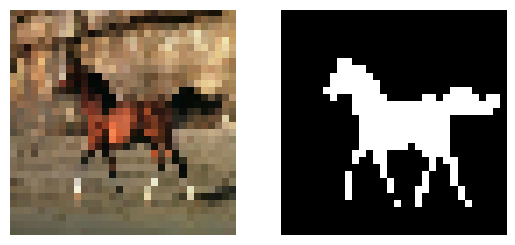

In [ ]:
 draw(xdata[0], ydata[0])

In [ ]:
train_size = xdata.shape[0]
batch_size = 10
train_dataset = (tf.data.Dataset.from_tensor_slices(np.hstack((xdata, ydata)))
                 .shuffle(train_size).batch(batch_size))

The intersection over union (IOU) is a metric for measuring the performance of image segmentation. The perfect segmentation receives IOU of one.

In [ ]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    return np.average(intersect / (union+0.0))


In [ ]:
assert iou(ydata, ydata) == 1.0

We can use feedforwad MLP or CNN  model for image segmentation. Here the input is the image and the output is the segmentation mask.

In [ ]:
class NeuralNet(tf.keras.Model):
    # Implement U-Net

    def construct_UNet_CNN(self, num_filters=32):
        def encode_block(inputs, num_filters=32, dropout=0.3, max_pooling=True, reg_coeff=-0.2):
            # Conv-Conv-Pool, store the outputs before pooling so that we can feed them into the decode blocks
            # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
            conv1 = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu',
                                           dtype='float32' , kernel_initializer = "he_normal",
                                           kernel_regularizer=tf.keras.regularizers.l2(reg_coeff),
                                           bias_regularizer=tf.keras.regularizers.l2(reg_coeff), padding='same')(inputs)

            conv2 = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu',
                                           dtype='float32' , kernel_initializer = "he_normal",
                                           kernel_regularizer=tf.keras.regularizers.l2(reg_coeff),
                                           bias_regularizer=tf.keras.regularizers.l2(reg_coeff), padding='same')(conv1)

            # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
            norm = tf.keras.layers.BatchNormalization()(conv2, training=False)


            # https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D
            new_layer = None
            if max_pooling:
                new_layer = tf.keras.layers.MaxPooling2D((2, 2))(norm)
            else:
                new_layer = norm

            # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
            if dropout:
                new_layer = tf.keras.layers.Dropout(dropout)(new_layer)

            save_outputs = norm
            return [new_layer, save_outputs]

        def decode_block(inputs, save_inputs, num_filters=32, dropout=0.3, reg_coeff=-0.2):
            # Transpose Conv, feed saved inputs, then Conv twice
            # print(inputs)
            # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose
            trans = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=(5, 5), activation='relu', kernel_initializer = "he_normal", padding="same", strides=(2, 2),
                                                    kernel_regularizer=tf.keras.regularizers.l2(reg_coeff),
                                                    bias_regularizer=tf.keras.regularizers.l2(reg_coeff))(inputs)

            # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate
            # Feed in and remember original structure
            merged = tf.keras.layers.concatenate([trans, save_inputs], axis=3)
            merged = tf.expand_dims(merged, axis=0)

            conv1 = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu',
                                           dtype='float32' , kernel_initializer = "he_normal",
                                           kernel_regularizer=tf.keras.regularizers.l2(reg_coeff),
                                           bias_regularizer=tf.keras.regularizers.l2(reg_coeff), padding='same')(merged)

            conv2 = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu',
                                           dtype='float32' , kernel_initializer = "he_normal",
                                           kernel_regularizer=tf.keras.regularizers.l2(reg_coeff),
                                           bias_regularizer=tf.keras.regularizers.l2(reg_coeff), padding='same')(conv1)

            if dropout:
                conv2 = tf.keras.layers.Dropout(dropout)(conv2)

            return conv2

        inputs = tf.keras.layers.Input((32, 32, 3))

        # e1 = encode_block(inputs)
        # e2 = encode_block(e1[0], num_filters=num_filters * 2)
        # e3 = encode_block(e2[0], num_filters=num_filters * 4)
        # e4 = encode_block(e3[0], num_filters=num_filters * 8)
        # e5 = encode_block(e4[0], num_filters=num_filters * 16, max_pooling=False)

        # d1 = decode_block(e5[0], e4[1], num_filters=num_filters * 8)
        # d2 = decode_block(d1[0], e3[1], num_filters=num_filters * 4)
        # d3 = decode_block(d2[0], e2[1], num_filters=num_filters * 2)
        # d4 = decode_block(d3[0], e1[1])


        e1 = encode_block(inputs)
        e2 = encode_block(e1[0], num_filters=num_filters * 2)
        e3 = encode_block(e2[0], num_filters=num_filters * 4, max_pooling=False)

        d1 = decode_block(e3[0], e2[1], num_filters=num_filters * 2)
        d2 = decode_block(d1[0], e1[1])

        # print(tf.shape(tf.squeeze(d4, axis=0)))
        d2 = tf.squeeze(d2, axis=0)
        # print(tf.shape(d4))

        o1 = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu',
                                    dtype='float32' , kernel_initializer = "he_normal",
                                    padding='same')(d2)

        o2 = tf.keras.layers.Conv2D(1, (1, 1),
                                    padding='same', activation='relu')(d2)

        # o2 = tf.reshape(o2, (32, 32, 3))
        # o2 = tf.squeeze(o2)
        print(tf.shape(o2))
        f = tf.keras.layers.Flatten()(o2)
        # o3 = tf.keras.layers.Dense(256, activation='relu',
        #                                kernel_regularizer=tf.keras.regularizers.l2(-0.),
        #                                bias_regularizer=tf.keras.regularizers.l2(-0.))(f)

        # o4 = tf.keras.layers.Dense(image_size * image_size)(o3)

        unet_model = tf.keras.Model(inputs=inputs, outputs=f)

        return unet_model




    def construct_CNN(self):
        self.model = tf.keras.Sequential(
            [
                # Since there is a dense layer at the bottom, this is has the same representation power as an MLP
                # ~60% IOU
                # tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), dtype='float32' ,
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2), padding='same'),
                # tf.keras.layers.MaxPooling2D((2, 2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', dtype='float32',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.MaxPooling2D((2, 2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3),
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(32, kernel_size=(5, 5),
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Flatten(),
                # tf.keras.layers.Dense(32, activation='relu',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.Dropout(.5),
                # tf.keras.layers.BatchNormalization(),
                # tf.keras.layers.Dropout(.5),
                # tf.keras.layers.Dense(image_size*image_size)

                # tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                # tf.keras.layers.Conv2D(16, (3, 3), activation='relu', dtype='float32' ,
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # # tf.keras.layers.MaxPooling2D((2, 2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2D(32, (3, 3), activation='relu', dtype='float32',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', dtype='float32',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', dtype='float32',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # # tf.keras.layers.MaxPooling2D((2, 2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3),
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3),
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3),
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3),
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2D(3, (3, 3), activation='relu', dtype='float32', padding='same',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # tf.keras.layers.Conv2D(1, (3, 3), activation='relu', dtype='float32', padding='same',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.2),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.2)),
                # # tf.keras.layers.BatchNormalization(),
                # # tf.keras.layers.Dropout(.5),
                # tf.keras.layers.Flatten(),

                # ~61% IOU
                # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), dtype='float32' , kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.), padding='same'),
                # tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.)),
                # tf.keras.layers.MaxPooling2D((2, 2)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(32, kernel_size=(2, 2), activation='relu',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(32, kernel_size=(2, 2), activation='relu',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), activation='relu',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Flatten(),
                # tf.keras.layers.Dense(64, activation='relu',
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.)),
                # tf.keras.layers.Dropout(.5),
                # tf.keras.layers.BatchNormalization(),
                # tf.keras.layers.Dropout(.5),
                # tf.keras.layers.Dense(image_size*image_size)

                # tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3), dtype='float32' , kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1), padding='same'),
                # tf.keras.layers.Conv2D(32, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                # tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2D(64, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                # tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), activation='relu', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                # tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Flatten(),
                # # tf.keras.layers.Dropout(.5),
                # tf.keras.layers.Dense(64, activation='relu', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-2.0),
                #                        bias_regularizer=tf.keras.regularizers.l2(-2.0)),
                # tf.keras.layers.Dropout(.8),
                # tf.keras.layers.Dense(32, activation='relu', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-2.0),
                #                        bias_regularizer=tf.keras.regularizers.l2(-2.0)),
                # tf.keras.layers.Dropout(.8),
                # tf.keras.layers.BatchNormalization(),
                # tf.keras.layers.Dropout(.8),
                # tf.keras.layers.Dense(image_size*image_size)

                # CNN, try to keep a low number of parameters
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Conv2D(4, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal",
                                       kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                                       bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                tf.keras.layers.Dropout(.3),
                tf.keras.layers.Conv2D(8, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal",
                                       kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                                       bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2D(8, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(.3),
                tf.keras.layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', kernel_initializer = "he_normal",
                                       kernel_regularizer=tf.keras.regularizers.l2(-0.1)),
                tf.keras.layers.Dropout(.3),
                tf.keras.layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', kernel_initializer = "he_normal",
                                       kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                                       bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                tf.keras.layers.Dropout(.3),
                # tf.keras.layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', kernel_initializer = "he_normal",
                #                        kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                #                        bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(.3),
                tf.keras.layers.Conv2D(3, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal", padding='same',
                                       kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                                       bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                tf.keras.layers.Dropout(.3),
                tf.keras.layers.Conv2D(1, (3, 3), activation='relu', dtype='float32', kernel_initializer = "he_normal", padding='same',
                                       kernel_regularizer=tf.keras.regularizers.l2(-0.1),
                                       bias_regularizer=tf.keras.regularizers.l2(-0.1)),
                tf.keras.layers.Dropout(.5),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Flatten(),
            ]
        )

        # self.model = self.construct_UNet_CNN(num_filters=4)


    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )


    def __init__(self, network_type = 'MLP'):
        super(NeuralNet, self).__init__()

        # SGD is stochastic gradient descent with momentum.
        # I am using jit_compile to speed up calculations
        # There are a list of useful parameters that can be adjusted:
        # learning_rate (first parameter)
        # momentum: number from 0 to 1
        # weight_decay: number from 0 to 1
        # However there are some that we haven't learned about yet:
        # clipnorm, clipvalue, global_clipnorm, use_ema, ema_momentum, ema_overwrite_frequency
        # self.optimizer = tf.keras.optimizers.SGD(0.01, weight_decay=0.05, jit_compile=True)

        #What are the other available optimizers
        # Adadelta, Adafactor, Adagrad
        # Adam, AdamW
        # Ftrl
        # Lion
        # Nadam
        # Optimizer
        # RMSprop
        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
        #Test your code with different optimizers
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        self.network_type = network_type

        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();



    # x is the current horse picture that we want to get a mask for
    # forward computes a mask using x and returns it.
    # If predict = True, pass the model result through the sigmoid function
    # tf.nn.sigmoid computes the sigmoid of x element-wise
    # https://www.tensorflow.org/api_docs/python/tf/math/sigmoid
    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)

    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);

        # sigmoid_cross_entropy_with_logits computes the cross entropy loss between current prediction and test data using the sigmoid function.
        # This is best used for binary classification.
        # logits are the predictions made by the model
        # labels are the true data/test data that we need to test our predictions against
        # logits and labels must be tensors of the same size
        # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);


        return tf.reduce_sum(cross_ent)


    @tf.function(jit_compile=True)
    def train_step(self, xbatch,ybatch):

        # tf.GradientTape records the operations within functions (like y = mx + b) within the context (loss) so that we can take the gradient later
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)


        # Using the information stored in the tape, GradientTape.gradient() computes the gradient of the loss function over all trainable parameters
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient
        gradients = tape.gradient(loss, model.trainable_variables)


        # Based on the algorithm of the optimizer, we apply the gradients to the weights
        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return tf.reduce_sum(loss) # total sum of a tensor -- total loss

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


In [ ]:
model = NeuralNet('CNN')
# model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

In [ ]:
model.model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_228 (Conv2D)         (None, 30, 30, 4)         112       
                                                                 
 dropout_172 (Dropout)       (None, 30, 30, 4)         0         
                                                                 
 conv2d_229 (Conv2D)         (None, 28, 28, 8)         296       
                                                                 
 dropout_173 (Dropout)       (None, 28, 28, 8)         0         
                                                                 
 batch_normalization_58 (Ba  (None, 28, 28, 8)         32        
 tchNormalization)                                               
                                                                 
 dropout_174 (Dropout)       (None, 28, 28, 8)         0         
                                                     

In [ ]:
#Adopt similar training loop for other problems

max_epoch = 5000

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);

    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");


    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))

    epoch += 1


Epoch 1, Loss: 2.03e+05, IOU - Train: 0.0199 Valid: 0.0158 Test: 0.0259
Epoch 2, Loss: 1.42e+05, IOU - Train: 0.003 Valid: 0.00241 Test: 0.0259
Epoch 3, Loss: 1.41e+05, IOU - Train: 0.00187 Valid: 0.00143 Test: 0.0259
Epoch 4, Loss: 1.4e+05, IOU - Train: 0.00169 Valid: 0.00106 Test: 0.0259
Epoch 5, Loss: 1.39e+05, IOU - Train: 0.00148 Valid: 0.000878 Test: 0.0259
Epoch 6, Loss: 1.38e+05, IOU - Train: 0.00127 Valid: 0.0007 Test: 0.0259
Epoch 7, Loss: 1.37e+05, IOU - Train: 0.0011 Valid: 0.000644 Test: 0.0259
Epoch 8, Loss: 1.36e+05, IOU - Train: 0.000983 Valid: 0.000533 Test: 0.0259
Epoch 9, Loss: 1.35e+05, IOU - Train: 0.000903 Valid: 0.000534 Test: 0.0259
Epoch 10, Loss: 1.35e+05, IOU - Train: 0.000824 Valid: 0.000477 Test: 0.0259
Epoch 11, Loss: 1.34e+05, IOU - Train: 0.00075 Valid: 0.000352 Test: 0.0259
Epoch 12, Loss: 1.33e+05, IOU - Train: 0.000757 Valid: 0.000352 Test: 0.0259
Epoch 13, Loss: 1.33e+05, IOU - Train: 0.000617 Valid: 0.000295 Test: 0.0259
Epoch 14, Loss: 1.32e+05, IO

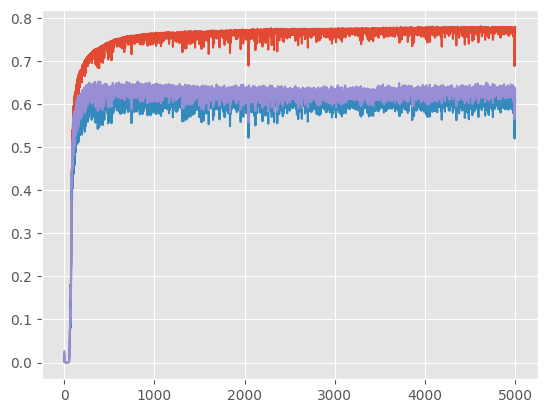

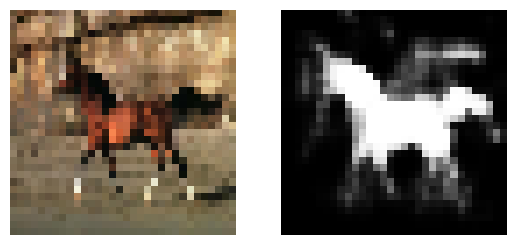

In [ ]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax)
pd.Series(val_iou).plot(ax=ax)
pd.Series(test_iou).plot(ax=ax)
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [ ]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

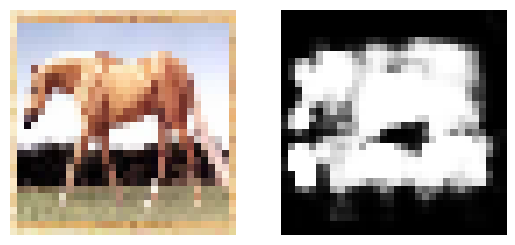

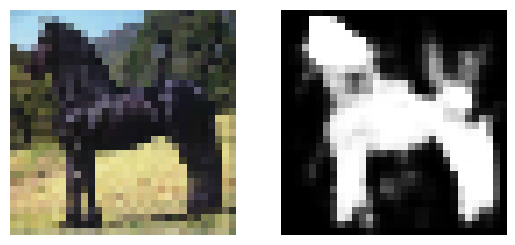

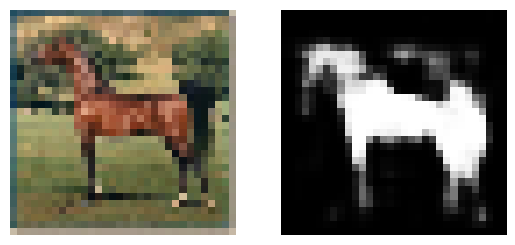

In [ ]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [ ]:
iou(ytest, ypred)

0.6467309461389139